# Training YOLOv11l-Pose for ODB Box Corner Detection and Object Detection

This notebook trains a YOLOv11l-Pose model to detect the ODB box and its four corners. The workflow is as follows:

1.   Setup: Environment Setup.
2.   Data: Download the dataset from GCS.
3.   Train: Train the yolov11l-pose model on the custom data.
4.   Validate: Run validation to get the final mAP scores.
5.   Save: Save the best-performing model (best.pt) back to GCS.

Reference: https://docs.ultralytics.com/tasks/pose/

## 1 Environment Setup

### 1.1 Install Libraries

We'll install ultralytics, which contains all the code for YOLOv11. The --quiet flag keeps the output clean.

In [ ]:
# Install the YOLOv11 library
#!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.3 MB/s eta 0:00:00


### 1.2 Set Project ID and Import Libraries

This step initializes the environment by importing the necessary Python libraries (os, yaml, YOLO) and configures the gcloud command-line tool by setting your Google Cloud PROJECT_ID. This ensures that subsequent commands (like downloading data with gsutil) are executed against the correct Google Cloud project.

In [ ]:
import os
import yaml
from ultralytics import YOLO
from IPython.display import Image

# Set your project ID
PROJECT_ID = "mobily-genai" 
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


## 2 Data Preparation & Inspection
This step defines the paths to your dataset, downloads the data from Google Cloud Storage (GCS) or a similar location, and updates the local data configuration file (data.yaml) to ensure all paths are correct for the training environment.

### 2.1 Define Paths and Download Data

In [ ]:
# --- Configuration ---
BUCKET_NAME = "visualiq-validation-dataset"
GCS_PATH = "dataset"

LOCAL_DATA_PATH = "/content/dataset"
# ---------------------

# Create the local directory
!mkdir -p {LOCAL_DATA_PATH}

# Copy the entire dataset (train, valid, test, data.yaml)
print("Copying dataset from GCS... This may take a moment.")
!gsutil -m cp -r gs://{BUCKET_NAME}/{GCS_PATH}/* {LOCAL_DATA_PATH}/

print("Copy complete. Verifying files:")
!ls -l {LOCAL_DATA_PATH}

Copying dataset from GCS... This may take a moment.
Copying gs://mobily-visualiq-validation-dataset/dataset/data.yaml...
Copying gs://mobily-visualiq-validation-dataset/dataset/test/images/19686857_Odb-open-_-signal_png_jpg.rf.5f134666c5d00e68053aacd62a328364.jpg...
Copying gs://mobily-visualiq-validation-dataset/dataset/test/images/19699369_OPEN-ODB-OUT_png_jpg.rf.a9325b86ea3accc5eb27c946df6ca6a2.jpg...
Copying gs://mobily-visualiq-validation-dataset/dataset/test/images/19667465_Open-ODB-pic_png_jpg.rf.771193326165b200d6960ca48e96c394.jpg...
Copying gs://mobily-visualiq-validation-dataset/dataset/test/images/20009825_OPEN-ODB_png_jpg.rf.f2bdd49b59ed2f695e6cf3d9044e8dc4.jpg...
Copying gs://mobily-visualiq-validation-dataset/dataset/test/images/21403664_Open-Odb_png_jpg.rf.bb22cf9ef4cd1db01437045822369f86.jpg...
Copying gs://mobily-visualiq-validation-dataset/dataset/test/images/19671156_Open-Odb_png_jpg.rf.13281df0e52fb638c08771cc9e6a72cb.jpg...
Copying gs://mobily-visualiq-validation-

### 2.2 Update Data YAML for Local Training

This code block performs path normalization by ensuring the YOLO training script can correctly locate images and labels in the new environment. Datasets downloaded from cloud storage often contain invalid file paths in their configuration (`data.yaml`); therefore, this script uses Python's `yaml` and `os` libraries to open the configuration file and programmatically overwrite the `train`, `val`, and `test` entries with the correct, absolute paths corresponding to where the data was just saved locally `(e.g., /content/dataset/train/images)`, making the data accessible to the training pipeline.

In [ ]:
DATA_YAML_PATH = os.path.join(LOCAL_DATA_PATH, "data.yaml")

# Read the YAML file
try:
    with open(DATA_YAML_PATH, 'r') as f:
        data = yaml.safe_load(f)

    # Update the paths to be absolute
    data['train'] = os.path.join(LOCAL_DATA_PATH, 'train/images')
    data['val'] = os.path.join(LOCAL_DATA_PATH, 'valid/images')
    data['test'] = os.path.join(LOCAL_DATA_PATH, 'test/images')

    # Write the updated data back to the file
    with open(DATA_YAML_PATH, 'w') as f:
        yaml.dump(data, f)

    print("Successfully updated data.yaml paths!")
    print("\n--- New data.yaml content: ---")
    !cat {DATA_YAML_PATH}

except Exception as e:
    print(f"ERROR: Could not find or update data.yaml at {DATA_YAML_PATH}")
    print("Please check your GCS_PATH in Step 2.")

Successfully updated data.yaml paths!

--- New data.yaml content: ---
flip_idx:
- 0
- 1
- 2
- 3
kpt_shape:
- 4
- 3
names:
- ODB_Box
nc: 1
roboflow:
  license: Private
  project: testing-few-images-riggv
  url: https://app.roboflow.com/viq/testing-few-images-riggv/3
  version: 3
  workspace: viq
test: /content/dataset/test/images
train: /content/dataset/train/images
val: /content/dataset/valid/images


## 3 Model Configuration & Training (YOLOv11-Large)
This code block performs the core fine-tuning. It loads the **YOLOv11-Large** Pose pre-trained weights (`yolo11l-pose.pt`) and starts the training process for 100 epochs on custom data, using the configured paths. The `patience` argument is set to manage the training duration and save the model that achieves the best accuracy.

In [ ]:
# Load a pre-trained large-sized pose model
model = YOLO("yolo11l-pose.pt")

print("--- Starting model training ---")

# Train the model
results = model.train(
    data=DATA_YAML_PATH,
    imgsz=640,
    epochs=100,
    patience=20, # Stops training if validation mAP50-95 doesn't improve for 20 epochs
    name="yolov11l_custom_pose" # Name for the results folder
)

print("--- Training complete ---")

--- Starting model training ---
Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22563MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11l_custom_pose3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

## 4 Evaluation and Final Validation

After training is finished, we load the `best.pt` file—the set of weights that achieved the highest performance during training—and run a final, definitive validation on the reserved test set to confirm the model's accuracy.

### 4.1 Run Final Validation and Display Numerical Metrics

This step loads the most accurate model saved during training and runs a final assessment on the reserved test set to get the ultimate Box and Pose mAP scores

In [ ]:
# Load your best trained model
model = YOLO("runs/pose/yolov11l_custom_pose/weights/best.pt")

# Run validation on the 'test' split defined in your data.yaml
print("--- Running final validation on the test set ---")
metrics = model.val(split='test')

print("\n--- Key Metrics ---")
print(f"Box mAP50-95: {metrics.box.map}")
print(f"Pose mAP50-95: {metrics.pose.map}")

--- Running final validation on the test set ---
Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22563MiB)
YOLO11l-pose summary (fused): 199 layers, 26,130,679 parameters, 0 gradients, 90.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1464.1±541.0 MB/s, size: 68.8 KB)
val: Scanning /content/dataset/test/labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 36/36 55.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.9it/s 1.6s
                   all         36         36      0.998          1      0.995      0.938      0.892      0.916      0.908      0.894
Speed: 8.4ms preprocess, 14.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/runs/pose/val5

--- Key Metrics ---
Box mAP50-95: 0.9384285275871751
Pose mAP50-95: 0.8938622060159865


* **Box mAP50-95:** Bounding Box Accuracy. This is the Mean Average Precision (mAP) for object detection, averaged across Intersection over Union (IoU) thresholds ranging from $\mathbf{50\%}$ to $\mathbf{95\%}$.

* **Pose mAP50-95:** Keypoint Accuracy. This is the mAP for pose estimation, averaged across Object Keypoint Similarity (OKS) thresholds ranging from $\mathbf{50\%}$ to $\mathbf{95\%}$. This score confirms the model's precision in locating custom four ODB corner keypoints.

### 4.2 Visualize Training Results

This code block displays key visual artifacts generated during training, which are essential for quality control.

* `results.png`: Displays the Performance Dashboard. This plot shows how the loss values (e.g., box_loss, pose_loss) decreased and how the accuracy metrics (mAP) increased over time, allowing you to confirm if the model converged successfully.

    * **Loss Curves:** These show the model's learning effort. Look for consistent downward trends.

    * **box_loss:** Indicates the error in predicting the size and location of the object's bounding box.

    * **pose_loss:** The most critical loss for your task; it indicates the error in predicting the coordinates of the four ODB corner keypoints.

    * **kobj_loss:** Measures the confidence that the model has correctly detected and placed a keypoint near the ground truth.

    * **cls_loss:** Measures how accurately the model classifies the detected object (ensuring it's an ODB box).

    * **dfl_loss:** Measures the model's confidence in accurately placing the boundaries of the bounding box (improving edge precision).

* `val_batch0_pred.jpg`: Displays a Validation Sample. This image provides a visual sanity check by showing the model's bounding box and keypoint (ODB corner) predictions overlaid on sample images from the validation set.

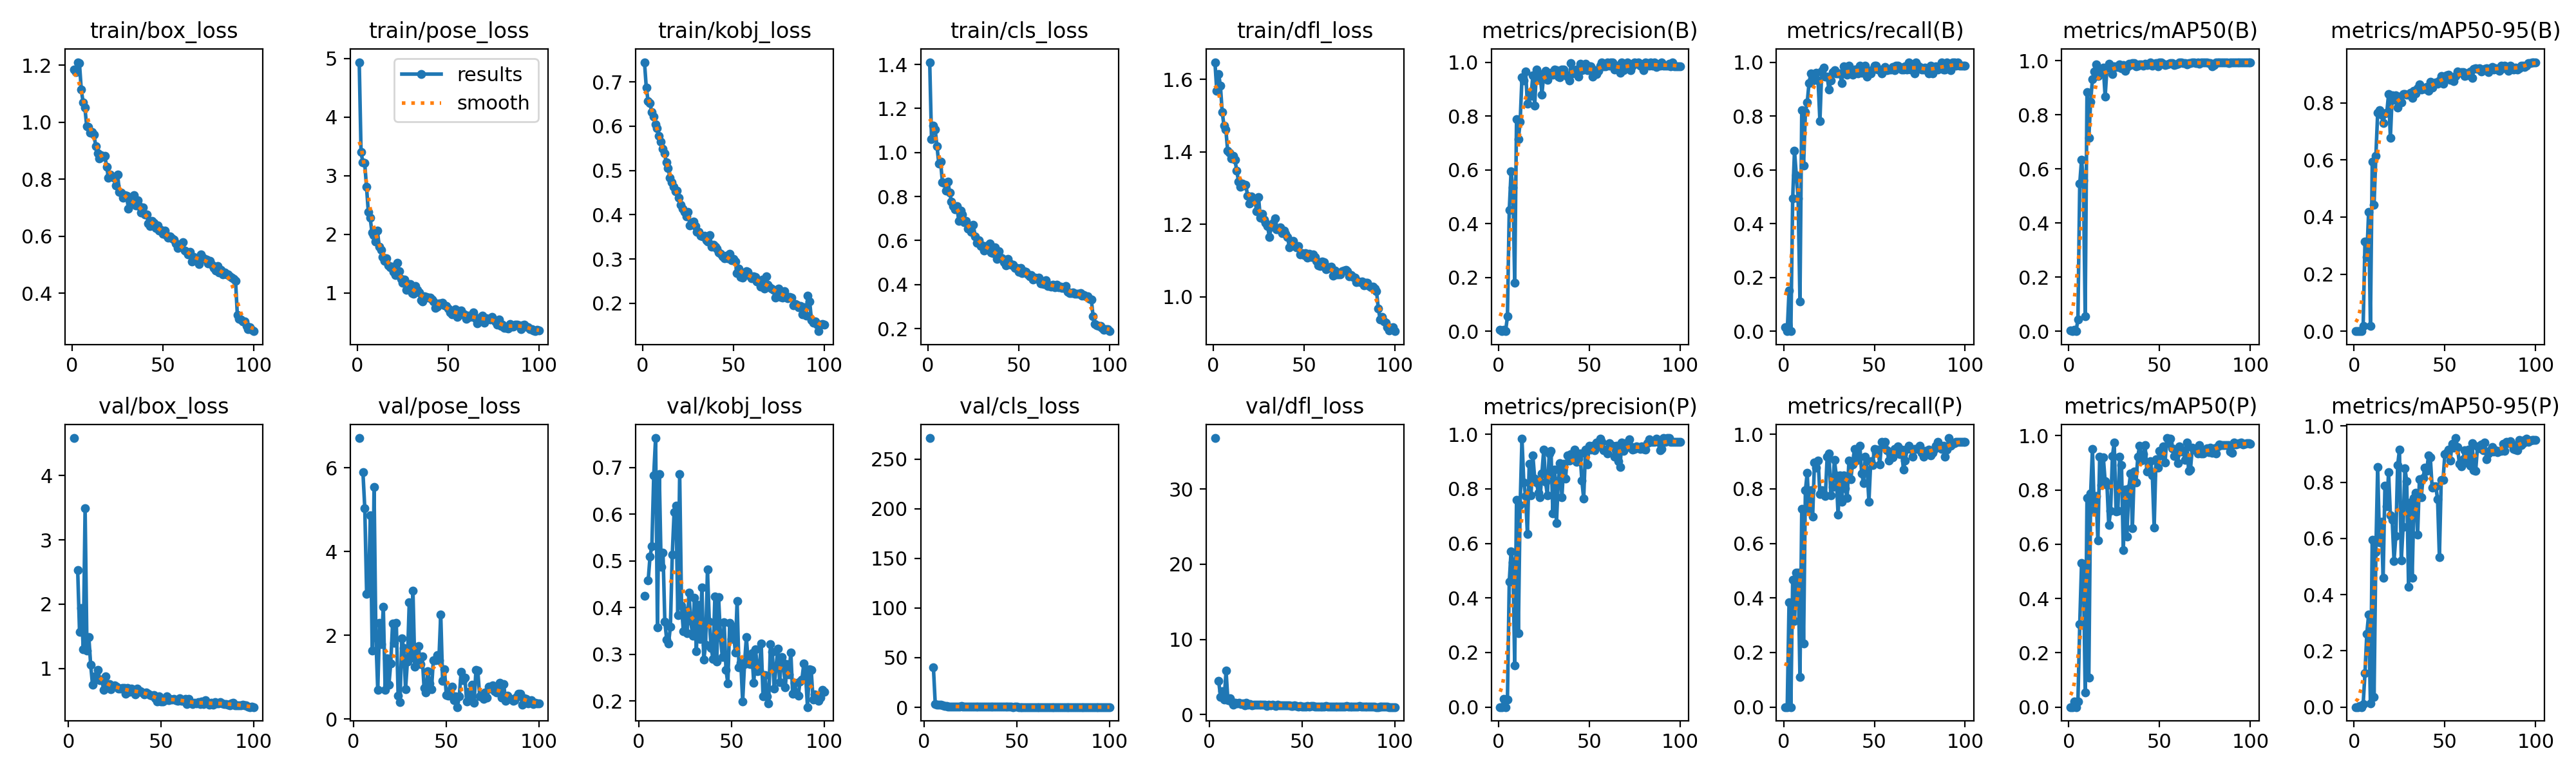

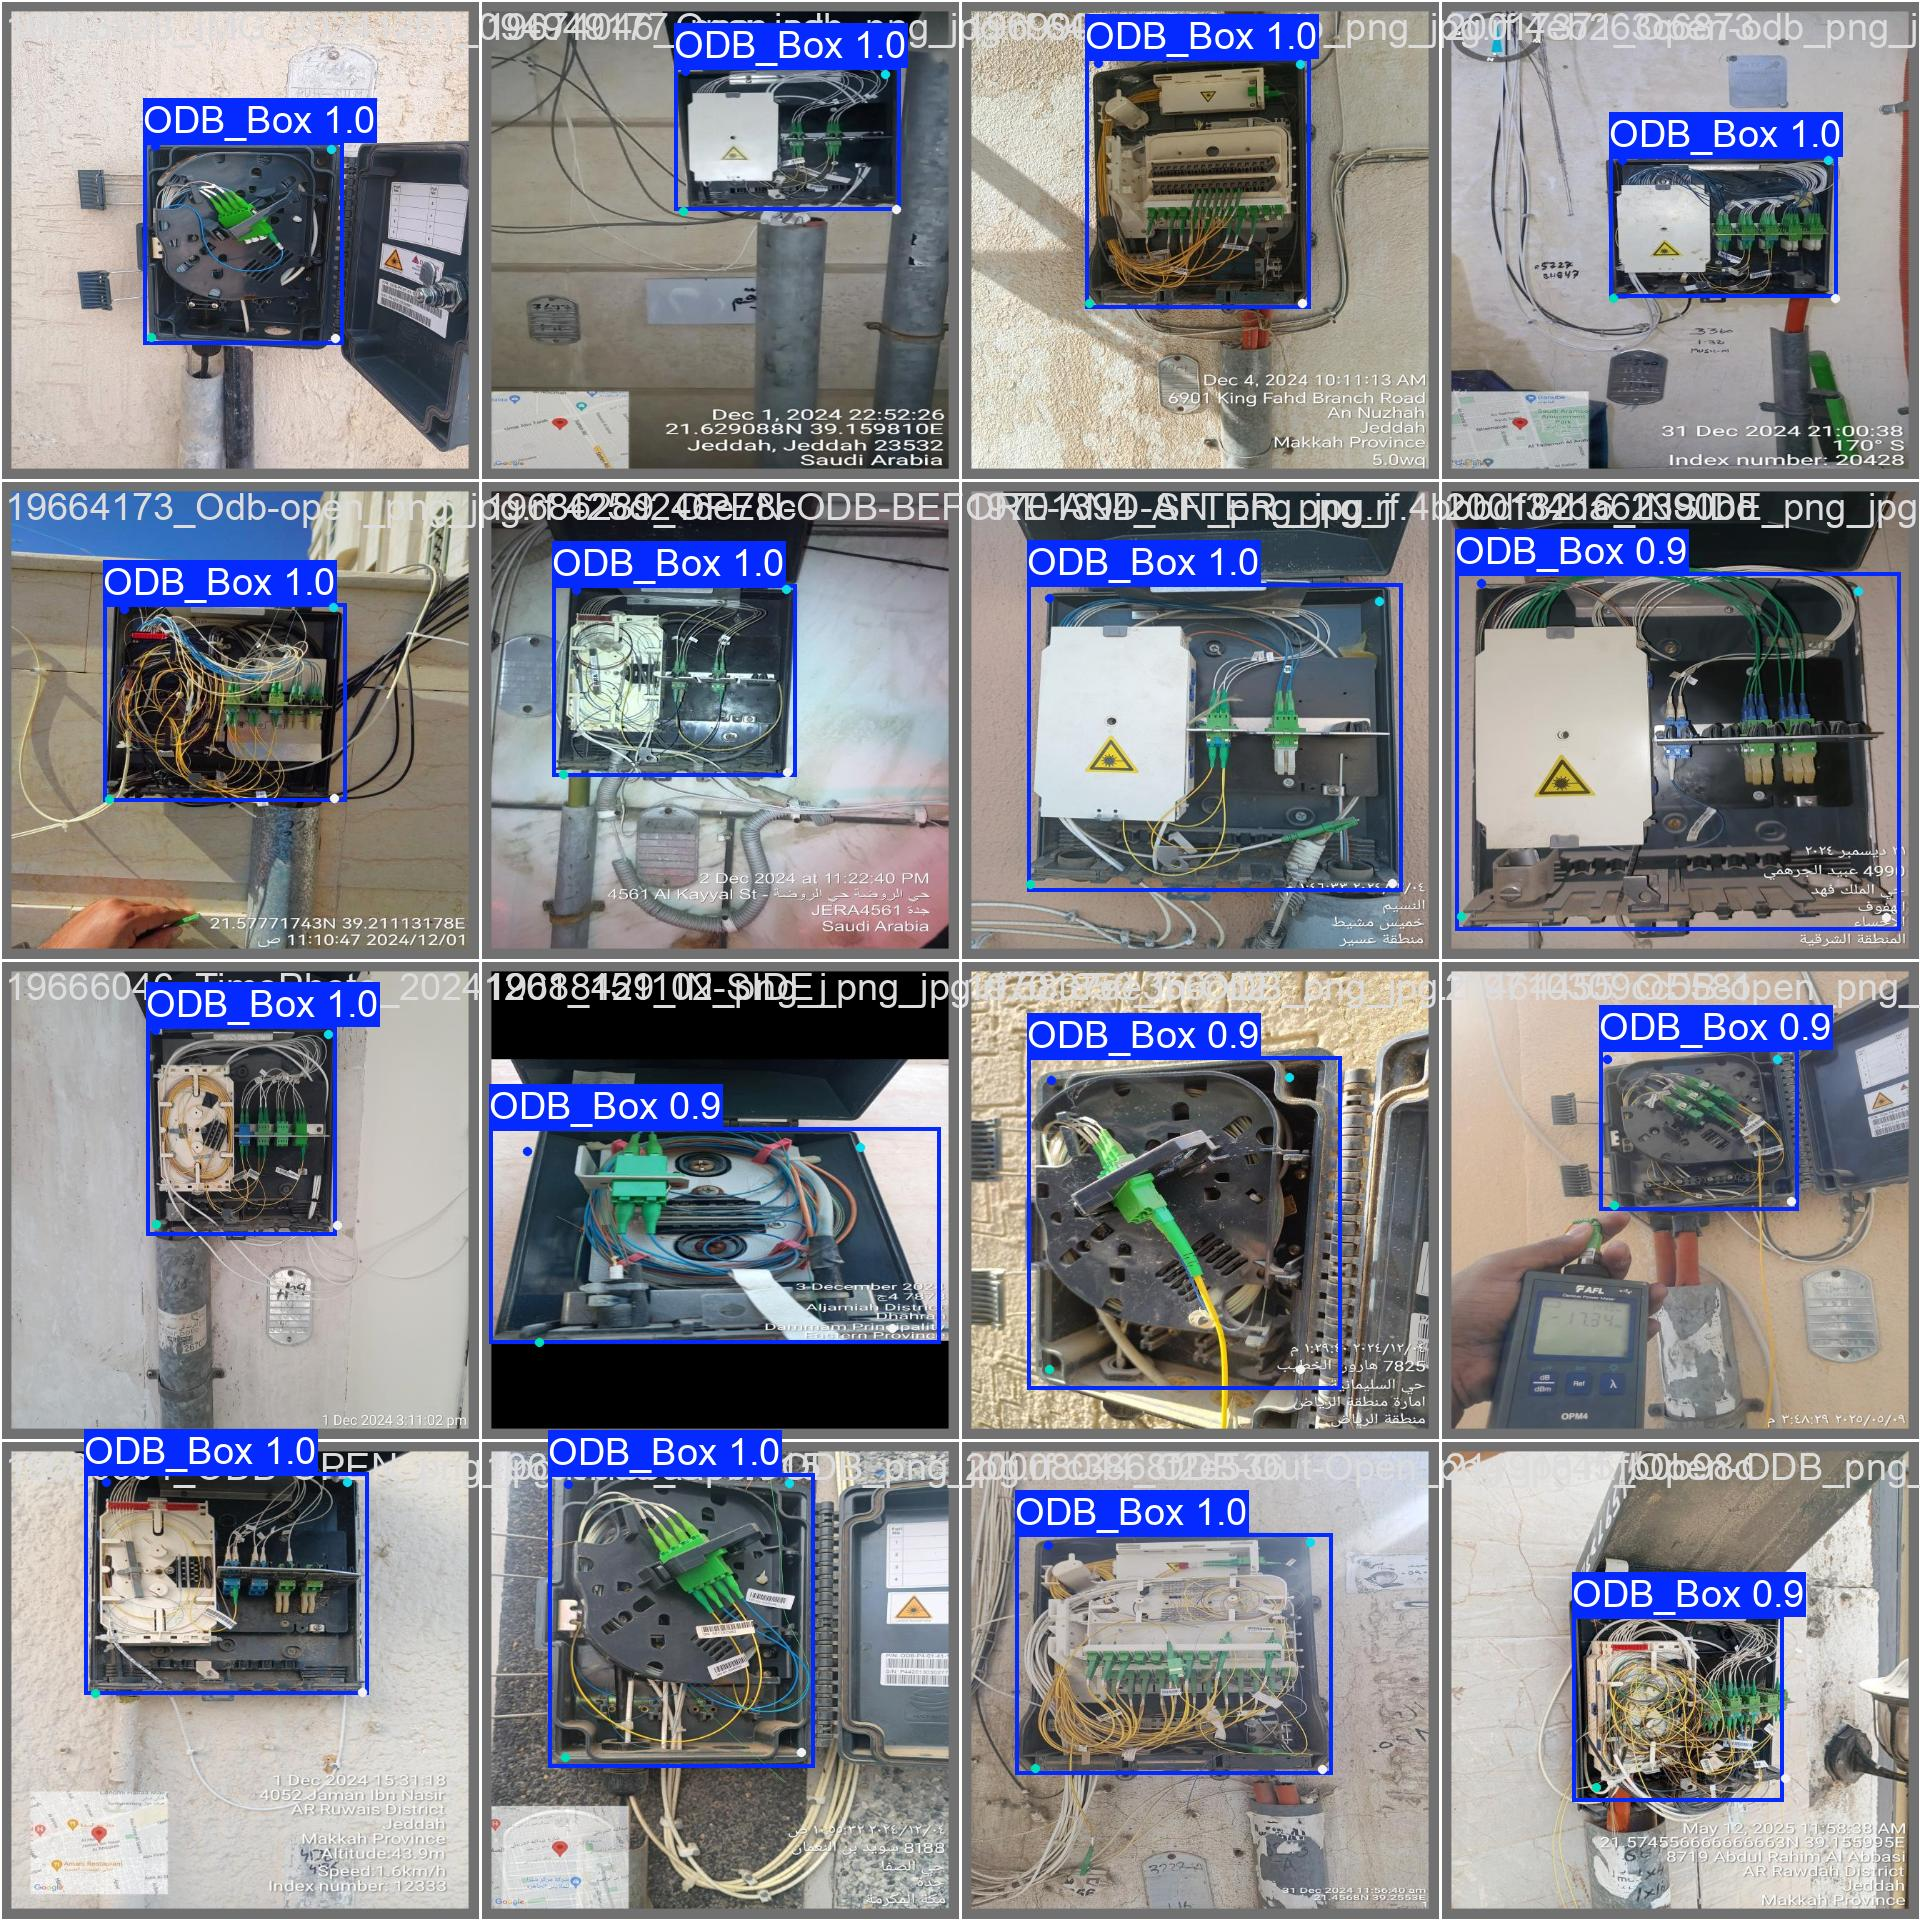

In [ ]:
# Display the main results plot
# This shows how your loss and mAP improved over time
display(Image(filename='runs/pose/yolov11l_custom_pose/results.png'))

# Display the validation samples
display(Image(filename='runs/pose/yolov11l_custom_pose/val_batch0_pred.jpg'))

## 5 Save the model in GCS

Securely save the entire training run folder to Google Cloud Storage (GCS). This ensures all training artifacts—including the logs, plots, and the best-performing PyTorch model (best.pt)—are saved for long-term storage and deployment.

In [ ]:
# Define the dedicated bucket name for storing the final model and results
MODEL_BUCKET_NAME = "visualiq-models"

# Define the local run directory name
RUN_DIRECTORY = 'yolov11l_custom_pose' 

# Define the full GCS path for saving the training results
# The results will be saved under gs://[MODEL_BUCKET_NAME]/yolo-training-runs/yolov11l_custom_pose
GCS_RESULTS_PATH = f"gs://{MODEL_BUCKET_NAME}/yolo-training-runs/"

print(f"Copying the full run directory to GCS: {GCS_RESULTS_PATH}")

# Recursively copy the local run directory to GCS
!gsutil -m cp -r runs/pose/{RUN_DIRECTORY} {GCS_RESULTS_PATH}

print("\nAll results saved to the Model Storage Bucket!")

Copying results to gs://mobily-visualiq-validation-dataset/yolo-training-runs/...
Copying file://runs/pose/yolov11l_custom_pose/BoxF1_curve.png [Content-Type=image/png]...
Copying file://runs/pose/yolov11l_custom_pose/labels.jpg [Content-Type=image/jpeg]...
Copying file://runs/pose/yolov11l_custom_pose/results.png [Content-Type=image/png]...
Copying file://runs/pose/yolov11l_custom_pose/confusion_matrix.png [Content-Type=image/png]...
Copying file://runs/pose/yolov11l_custom_pose/args.yaml [Content-Type=application/octet-stream]...
Copying file://runs/pose/yolov11l_custom_pose/val_batch0_labels.jpg [Content-Type=image/jpeg]...
Copying file://runs/pose/yolov11l_custom_pose/confusion_matrix_normalized.png [Content-Type=image/png]...
Copying file://runs/pose/yolov11l_custom_pose/results.csv [Content-Type=text/csv]...
Copying file://runs/pose/yolov11l_custom_pose/PosePR_curve.png [Content-Type=image/png]...
Copying file://runs/pose/yolov11l_custom_pose/train_batch1.jpg [Content-Type=image/

## Conclusion

This notebook successfully trained and validated the YOLOv11-Large Pose model, achieving an exceptionally high level of accuracy and robustness on the ODB Box Corner Detection task.

* **Box mAP@50-95 $0.938$ Object Detection:** This score confirms the model's reliability in drawing the bounding box to detect the presence and location of the ODB box. This detection is critical for calculating the coverage ratio.

* **Pose mAP@50-95 $0.893$ Keypoint Detection (Corners):** This score confirms the precision in locating the four corner keypoints. These corners are essential for checking the completeness and integrity of the ODB box in the image verifying all four sides are visible.

The final, best-performing PyTorch model (best.pt) has been saved to Cloud Storage Bucket. The next steps involve deploying this file to for inference.